In [1]:
import pandas as pd

In [2]:
# df 为清洗好的数据
df = pd.read_csv('data_clean.csv')
df.head()
## csc: counter service for customer -- 选择柜台服务的客户
## ATM_POS: 使用 ATM 和 POS 服务的客户
## TBM：有偿服务

,ATM_POS,TBM,CSC
0,-0.852354,-0.294938,0.143935
1,-0.333078,-0.244334,0.939343
2,0.918067,0.593787,2.349496
3,-0.741847,-0.210507,-0.521592
4,-0.499703,-0.492714,-0.367629


## K-Means 聚类的第一种方式
###### 不进行变量分布的正太转换--用于寻找异常值

In [3]:
# 使用k-means聚类
## 1.1 k-means聚类的第一种方式：不进行变量分布的正态转换--用于寻找异常值

# 1、查看变量的偏度
var = ["ATM_POS","TBM","CSC"]  # var: variable-变量
skew_var = {}
for i in var:
    skew_var[i]=abs(df[i].skew()) # .skew() 求该变量的偏度
    skew=pd.Series(skew_var).sort_values(ascending=False)
skew

TBM        51.881233
CSC         6.093417
ATM_POS     2.097633
dtype: float64

In [4]:
# 进行k-means聚类
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3) # n_clusters=3 表示聚成3类
# kmeans = cluster.KMeans(n_clusters=3, init='random', n_init=1)
result = kmeans.fit(df)
result

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [5]:
# 对分类结果进行解读
model_data_l = df.join(pd.DataFrame(result.labels_)) 
                            # .labels_ 表示这一个数据点属于什么类
model_data_l = model_data_l.rename(columns={0: "clustor"})
model_data_l.sample(10)

,ATM_POS,TBM,CSC,clustor
75557,-0.660390,-0.491282,-0.473513,1
87072,3.435500,0.606897,0.272691,0
66524,-0.890393,1.158563,1.957567,2
348,-0.885561,-0.411805,-0.506717,1
62663,-0.592656,0.413549,-0.374998,1
51898,2.343226,1.188243,0.198308,0
65429,-0.885617,0.309940,0.152809,1
53632,0.059517,-0.171865,-0.476880,1
87599,-0.562473,-0.025141,-0.540707,1
59717,-0.380191,0.043765,-0.320864,1


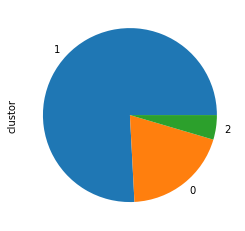

In [6]:
# 饼图呈现
import matplotlib
get_ipython().magic('matplotlib inline')
model_data_l.clustor.value_counts().plot(kind = 'pie') 
# 自然就能发现出现分类很不平均的现象

结合前面的求每个变量的偏度：

    TBM        51.881233
    CSC         6.093417
    ATM_POS     2.097633

其中 TBM 这个变量的偏度异常，果然影响了分类情况（饼图可清晰看出很不平均）

##  k-means聚类的第二种方式
###### 进行变量分布的正态转换--用于客户细分

In [7]:
# 进行变量分布的正态转换
import numpy as np
from sklearn import preprocessing
quantile_transformer = \
    preprocessing.QuantileTransformer(output_distribution='normal', 
                                      random_state=0) # 正态转换
## 插播：转换的方式有很多种，每种都会涉及一些咋看起来比较晦涩的统计学公式
## 但请不要担心，每种代码其实都是比较固定的，
  ## 这里使用 QT 转换（每种转换的原理和特点优劣等可参考网络资源）

df_trans = quantile_transformer.fit_transform(df)
df_trans = pd.DataFrame(df_trans)  
 # 因为 .fit_transform 转换出来的数据类型为 Series，
    ## 所以用 pandas 给 DataFrame 化一下

df_trans = df_trans.rename(columns={0: "ATM_POS", 1: "TBM", 2: "CSC"})
df_trans.head()

,ATM_POS,TBM,CSC
0,-0.501859,-0.265036,0.770485
1,0.097673,-0.154031,1.316637
2,0.952085,1.168354,1.845934
3,-0.333179,-0.084688,-1.780166
4,-0.071278,-0.888898,-0.066404


In [8]:
# 检验一下偏度：发现几乎都为 0 了
var = ["ATM_POS","TBM","CSC"]
skew_var = {}
# 循环计算偏度：发现都差不多等于 0 了。
for i in var:
    skew_var[i] = abs(df_trans[i].skew())
    skew = pd.Series(skew_var).sort_values(ascending=False)
skew  # 字典显示更方便

CSC        0.000521
ATM_POS    0.000452
TBM        0.000091
dtype: float64

In [9]:
# 重复的聚类步骤，代码可直接粘贴
kmeans = KMeans(n_clusters=4)  # 这次聚成 4 类
result = kmeans.fit(df_trans)

model_data_l = df_trans.join(pd.DataFrame(result.labels_))
model_data_l = model_data_l.rename(columns={0: "clustor"})
model_data_l.head()

,ATM_POS,TBM,CSC,clustor
0,-0.501859,-0.265036,0.770485,1
1,0.097673,-0.154031,1.316637,3
2,0.952085,1.168354,1.845934,3
3,-0.333179,-0.084688,-1.780166,2
4,-0.071278,-0.888898,-0.066404,1


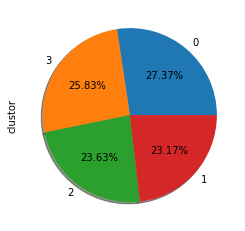

In [22]:
model_data_l.clustor.value_counts().plot(kind='pie',
                   shadow=True, autopct='%.2f%%') # 两位小数百分比